# Get MD from deribit option


In [24]:
import requests
md = requests.get('https://www.deribit.com/api/v2/public/get_book_summary_by_currency?currency=BTC&kind=option',headers={"Content-Type": "application/json"}).json()
btc_index = requests.get('https://www.deribit.com/api/v2/public/get_index_price?index_name=btc_usd',headers={"Content-Type": "application/json"}).json()['result']['index_price']

In [25]:
import pandas as pd
import numpy as np
import time
import matplotlib.pylab as plt
# !pip install py_vollib_vectorized
df = pd.DataFrame(md['result'])
df['kind'] = df['instrument_name'].str.split('-').apply(lambda x:x[-1])
df['strike'] = df['instrument_name'].str.split('-').apply(lambda x:int(x[2]))
df['expiry'] = df['instrument_name'].str.split('-').apply(lambda x: pd.Timestamp(x[1] + " 08:00:00"))
df['time'] = (df['expiry'] -  pd.Timestamp(time.time_ns()))/pd.Timedelta('365 days')
df['rate'] = np.log(df['underlying_price'] / btc_index ) / df['time']
# valid entries
# df = df[~df.mid_price.isna()]

import py_vollib.black.implied_volatility
# import py_vollib_vectorized


Text(0, 0.5, 'rate')

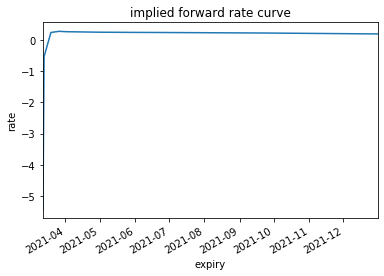

In [26]:
# underlying implied forward rate curve
p1 = df.groupby('expiry').rate.mean().plot()
p1.set_title('implied forward rate curve')
p1.set_ylabel('rate')

In [27]:
from py_vollib.black.implied_volatility import implied_volatility as iv
keys = ['mid_price','bid_price','ask_price']
for i in df.index:
    for k in keys:
        try:
            df.loc[i,k.split('_')[0]+'_vol'] = iv(df.loc[i,k]*btc_index, df.loc[i,'underlying_price'], df.loc[i,'strike'],max(df.loc[i,'rate'],0), df.loc[i,'time'],  df.loc[i,'kind'].lower())
        except:
            df.loc[i,k.split('_')[0]+'_vol'] = np.nan
df = df[['underlying_price', 'underlying_index', 'open_interest', 'mid_price', 'mark_price','last', 'instrument_name','bid_price', 'ask_price', 'kind', 'strike', 'expiry', 'time', 'rate', 'mid_vol', 'bid_vol', 'ask_vol']]


In [18]:
for i in df.index:
    kind = df.loc[i,'kind']
    if kind == 'P':
        continue
    for k in keys:
        kind = df.loc[i,'kind']
        other = 'P'
        keys = ['mid_vol','bid_vol','ask_vol']
        other_key = df.loc[i,'instrument_name'][::-1].replace(kind, other,1)[::-1]
        row = df.loc[df.instrument_name == other_key]
        for k in keys:
            # print(df.iloc[i,'instrument_name'].replace(kind, other))
            # print(np.isnan(df.loc[df.instrument_name == df.loc[i,'instrument_name'].replace(kind, other), k]))
            # print(row[k].isnan)
            if np.isnan(df.loc[i][k]):
                 df.loc[i, k] = df.loc[df.instrument_name == other_key, k].iloc[0]
            if 'ask' in k:
                mid = min(df.loc[df.instrument_name == other_key, k].iloc[0],df.loc[i, k])
            else:
                mid = max(df.loc[df.instrument_name == other_key, k].iloc[0],df.loc[i, k])
            df.loc[i, k] = mid

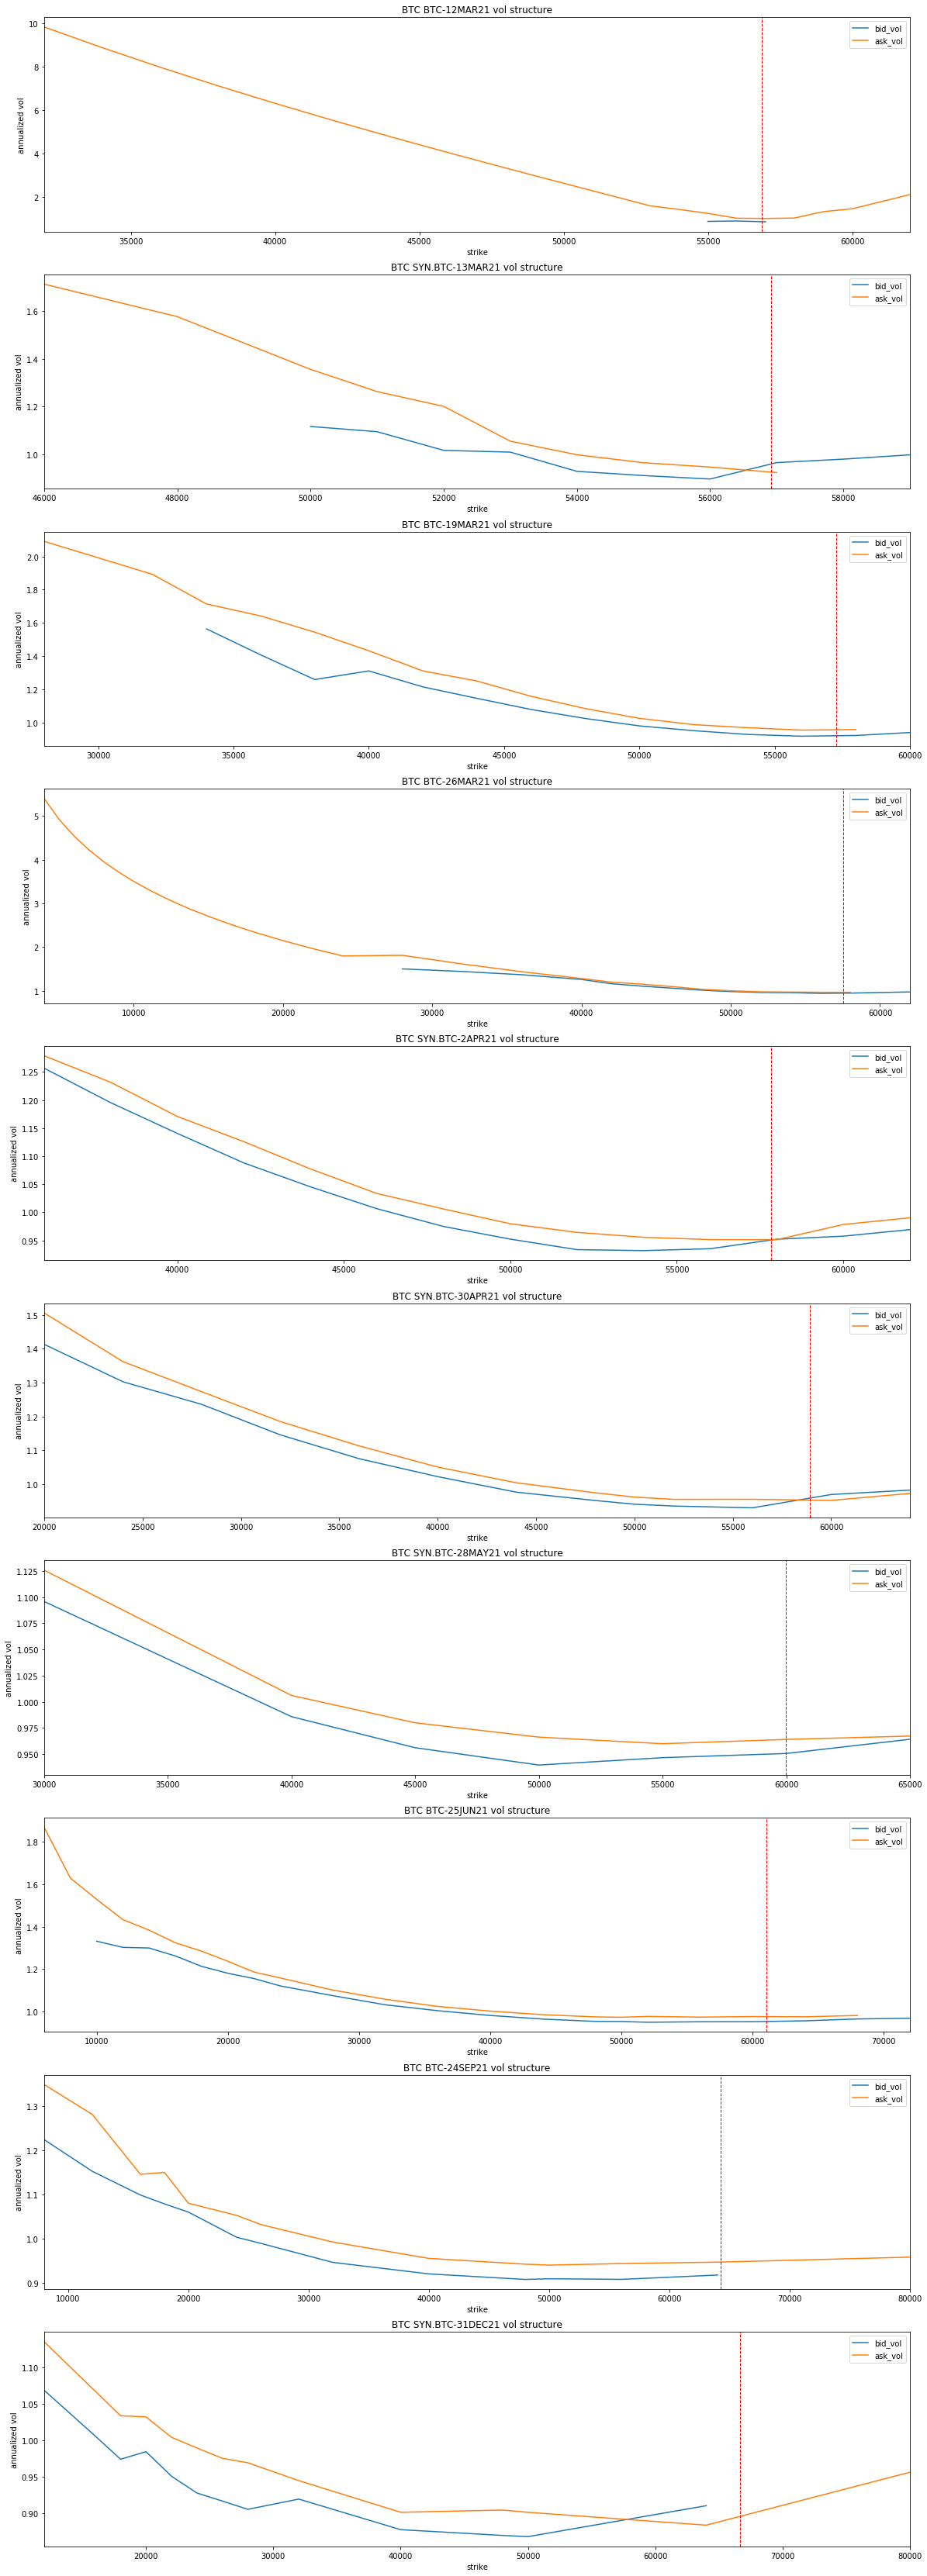

In [19]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=len(df.underlying_index.unique()), ncols=1, figsize=(20, 60))

for y, kind in enumerate('C'):
    for x, expiry in enumerate(sorted(df.time.unique())):
        interested_df = df[(df.kind==kind) & (df.time==expiry)]
        ax = interested_df.sort_values('strike')[['bid_vol','ask_vol','strike']].set_index('strike').dropna(how='all').plot(ax=axes[x])
        ax.set_title(f'BTC {interested_df.underlying_index.iloc[0]} vol structure')
        ax.set_ylabel('annualized vol')
        ax.axvline(x=interested_df.underlying_price.iloc[0], linewidth=1, color='r', ls='--', label='atm strike')
        # ax.text(interested_df.underlying_price.iloc[0],0,'atm strike',rotation=90)

In [48]:
for k in iv_map:
    iv_map[k].sort()
iv_map.keys()
iv_map[0]

NameError: name 'iv_map' is not defined

In [ ]:
df2 = pd.DataFrame(iv_map[0], columns=['strike','iv'])
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20,20))
i = 0
for k in sorted(iv_map.keys()):
    print(k)
    pd.DataFrame(iv_map[k], columns=['strike','iv']).set_index('strike').plot(ax=axes[i//3,i % 3], title=f'{k} days to expiry')
    i += 1
# df2.set_index('strike').plot()

In [ ]:
df.strike.unique(), df.expiry.unique(),df.rate.unique()

In [ ]:
df.head(1)

In [ ]:
py_vollib.black.implied_volatility.implied_volatility(262.3,)

In [ ]:
"7 14 21 28 56"
import py_vollib.black.implied_volatility as iv
iv.implied_volatility(38, 1000, 950, 0.1, 28/365,  'p'), iv.implied_volatility(76, 1000, 950, 0.1, 56/365,  'p')

In [ ]:
import pandas as pd
df = pd.DataFrame(columns=[7,14,21,28,56], data=[[.5,1,1.5,2,4],[1,2,3,4,8],[2,4,6,8,16],[1,2,3,4,8],[0.5,1,1.5,2,4]],index=[900,950,1000,1050,1100])
df = df.multiply(df.index/100,axis=0)
# df[df.index>1000].add(df.index>1000-1000, axis=0)
bigger = df[df.index>1000]
bigger = bigger.add(bigger.index -1000, axis=0)
df = df[df.index<=1000].append(bigger)
df
for i in range(5):
    for j in range(5):
        t = df.columns[i]
        k = df.index[j]
        try:
            # df.iloc[j, i] = (iv.implied_volatility(df.iloc[j,i], 1000, k, 0.0, t/365,  'p'))**2 / 365 * t * 10000 
            df.iloc[j, i] = iv.implied_volatility(df.iloc[j,i], 1000, k, 0.0, t/365,  'p')
        except:
            print(i,j,t, k, df.iloc[i,j], k,t)
df

In [ ]:
iv.implied_volatility(18,1000,900,0,28/365,'p')

In [27]:
df.iloc[0]

volume                                        0
underlying_price                        51257.7
underlying_index                    BTC-26MAR21
quote_currency                              USD
price_change                                NaN
open_interest                            2265.7
mid_price                                   NaN
mark_price                                6e-08
low                                         NaN
last                                     0.0085
interest_rate                                 0
instrument_name              BTC-26MAR21-8000-P
high                                        NaN
estimated_delivery_price                50748.5
creation_timestamp                1615222103994
bid_price                                   NaN
base_currency                               BTC
ask_price                                0.0005
kind                                          P
strike                                     8000
expiry                      2021-03-26 0